# **Namish Rathy**

# **E23CSEU0608**

# Objective:

To understand and implement adversarial attacks on deep learning models. Students
will gain hands-on experience in generating adversarial examples, testing model
robustness, and applying defense mechanisms on a CNN trained on the MNIST
dataset.

# Import

In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

# Data Set Loading

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


# Shape

In [4]:
print(f"Training set shape: {x_train.shape}, Labels: {y_train.shape}")
print(f"Test set shape: {x_test.shape}, Labels: {y_test.shape}")

Training set shape: (60000, 28, 28), Labels: (60000,)
Test set shape: (10000, 28, 28), Labels: (10000,)


# Checking For NA values

In [5]:
missing_values_train = np.isnan(x_train).sum()
missing_values_test = np.isnan(x_test).sum()
print(f"\nMissing values in training set: {missing_values_train}")
print(f"Missing values in test set: {missing_values_test}")


Missing values in training set: 0
Missing values in test set: 0


# Visual Samples

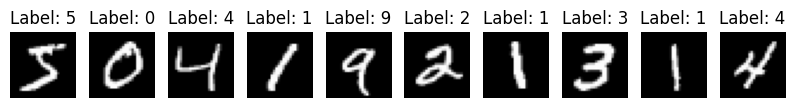

In [6]:
fig, axes = plt.subplots(1, 10, figsize=(10, 2))
for i in range(10):
    axes[i].imshow(x_train[i], cmap="gray")
    axes[i].set_title(f"Label: {y_train[i]}")
    axes[i].axis("off")
plt.show()

# Normalization

In [7]:
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# One-Hot Encoding

In [8]:
y_train_cat = keras.utils.to_categorical(y_train, 10)
y_test_cat = keras.utils.to_categorical(y_test, 10)

# Reshaping

In [9]:
print("x_train:", x_train.shape, "y_train:", y_train_cat.shape)
print("x_test:", x_test.shape, "y_test:", y_test_cat.shape)

x_train: (60000, 28, 28) y_train: (60000, 10)
x_test: (10000, 28, 28) y_test: (10000, 10)


# CNN Model

In [10]:
def build_cnn():
    he_init = keras.initializers.HeNormal()
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation="relu", padding="same", kernel_initializer=he_init, input_shape=(28,28,1)),
        layers.Conv2D(32, (3,3), activation="relu", padding="same", kernel_initializer=he_init),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3,3), activation="relu", padding="same", kernel_initializer=he_init),
        layers.Conv2D(64, (3,3), activation="relu", padding="same", kernel_initializer=he_init),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(128, activation="relu", kernel_initializer=he_init),
        layers.Dropout(0.25),
        layers.Dense(10, activation="softmax")
    ])
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

model = build_cnn()
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 467,818 (1.78 MB)

 Trainable params: 467,818 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

# Model Training

In [11]:
history = model.fit(
    x_train, y_train_cat,
    validation_split=0.2,
    epochs=12,
    batch_size=32,
    verbose=2
)

Epoch 1/12
1500/1500 - 15s - 10ms/step - accuracy: 0.9415 - loss: 0.1888 - val_accuracy: 0.9860 - val_loss: 0.0450
Epoch 2/12
1500/1500 - 14s - 10ms/step - accuracy: 0.9795 - loss: 0.0693 - val_accuracy: 0.9879 - val_loss: 0.0406
Epoch 3/12
1500/1500 - 6s - 4ms/step - accuracy: 0.9841 - loss: 0.0514 - val_accuracy: 0.9912 - val_loss: 0.0319
Epoch 4/12
1500/1500 - 11s - 7ms/step - accuracy: 0.9878 - loss: 0.0414 - val_accuracy: 0.9893 - val_loss: 0.0381
Epoch 5/12
1500/1500 - 6s - 4ms/step - accuracy: 0.9889 - loss: 0.0357 - val_accuracy: 0.9896 - val_loss: 0.0387
Epoch 6/12
1500/1500 - 6s - 4ms/step - accuracy: 0.9903 - loss: 0.0314 - val_accuracy: 0.9922 - val_loss: 0.0272
Epoch 7/12
1500/1500 - 10s - 7ms/step - accuracy: 0.9915 - loss: 0.0281 - val_accuracy: 0.9894 - val_loss: 0.0405
Epoch 8/12
1500/1500 - 10s - 7ms/step - accuracy: 0.9924 - loss: 0.0241 - val_accuracy: 0.9902 - val_loss: 0.0384
Epoch 9/12
1500/1500 - 10s - 7ms/step - accuracy: 0.9932 - loss: 0.0223 - val_accuracy: 0

# Accuracy & Loss

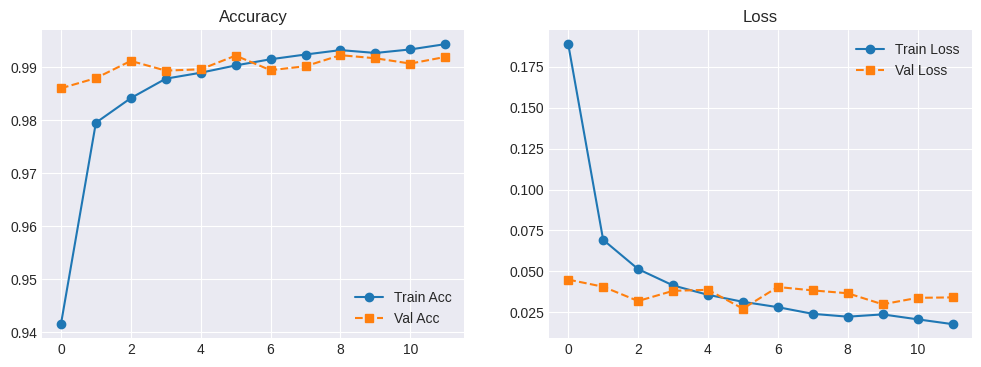

In [12]:
plt.style.use("seaborn-v0_8-darkgrid")

fig, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].plot(history.history['accuracy'], 'o-', label='Train Acc')
ax[0].plot(history.history['val_accuracy'], 's--', label='Val Acc')
ax[0].set_title("Accuracy"); ax[0].legend()

ax[1].plot(history.history['loss'], 'o-', label='Train Loss')
ax[1].plot(history.history['val_loss'], 's--', label='Val Loss')
ax[1].set_title("Loss"); ax[1].legend()

plt.show()


# FGSM

In [13]:
def fgsm_attack(model, images, labels, eps=0.25):
    with tf.GradientTape() as tape:
        tape.watch(images)
        preds = model(images)
        loss = keras.losses.categorical_crossentropy(labels, preds)
    grad = tape.gradient(loss, images)
    adv = images + eps * tf.sign(grad)
    return tf.clip_by_value(adv, 0, 1)

In [14]:
x_test_tf = tf.convert_to_tensor(x_test, dtype=tf.float32)
y_test_tf = tf.convert_to_tensor(y_test_cat, dtype=tf.float32)
x_test_adv = fgsm_attack(model, x_test_tf, y_test_tf, eps=0.25).numpy()

# Visualization

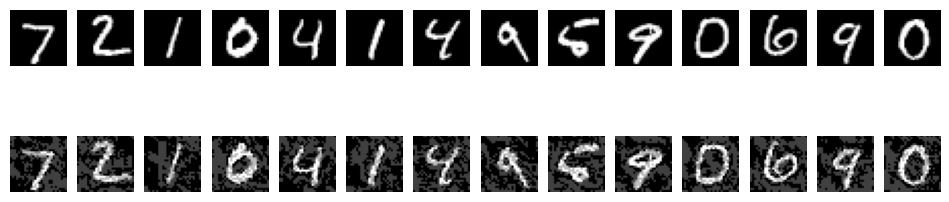

In [15]:
n = 14
plt.figure(figsize=(12,3))
for i in range(n):
    plt.subplot(2,n,i+1); plt.imshow(x_test[i].squeeze(), cmap="gray"); plt.axis("off")
    plt.subplot(2,n,n+i+1); plt.imshow(x_test_adv[i].squeeze(), cmap="gray"); plt.axis("off")
plt.show()

# Evaluating CNN

In [16]:
print("Clean accuracy:")
model.evaluate(x_test, y_test_cat, verbose=2)

print("Clean accuracy:")
model.evaluate(x_test, y_test_cat, verbose=2)

Clean accuracy:
313/313 - 3s - 11ms/step - accuracy: 0.9926 - loss: 0.0280
Clean accuracy:
313/313 - 1s - 2ms/step - accuracy: 0.9926 - loss: 0.0280


[0.02800377458333969, 0.9926000237464905]

# Adversarial Training

In [17]:
def adv_training(model, x_train, y_train, eps=0.25, epoch=7, batch_size=32):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        idx = np.random.permutation(len(x_train))
        x_train, y_train = x_train[idx], y_train[idx]
        for i in range(0, len(x_train), batch_size):
            xb = x_train[i:i+batch_size]
            yb = y_train[i:i+batch_size]
            xb_tf = tf.convert_to_tensor(xb, dtype=tf.float32)
            yb_tf = tf.convert_to_tensor(yb, dtype=tf.float32)
            adv_xb = fgsm_attack(model, xb_tf, yb_tf, eps)
            model.train_on_batch(np.concatenate([xb, adv_xb]), np.concatenate([yb, yb]))
    return model

robust_model = build_cnn()
robust_model = adv_training(robust_model, x_train, y_train_cat, eps=0.25, epochs=5)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5


# Accuracy Compare

In [18]:
print("Robust model (clean test):")
robust_model.evaluate(x_test, y_test_cat, verbose=2)
print("Robust model (adversarial test):")
robust_model.evaluate(x_test_adv, y_test_cat, verbose=2)

Robust model (clean test):
313/313 - 2s - 6ms/step - accuracy: 0.9926 - loss: 0.0247
Robust model (adversarial test):
313/313 - 1s - 2ms/step - accuracy: 0.9623 - loss: 0.1183


[0.11829068511724472, 0.9623000025749207]

# Report

In [19]:
clean_loss, clean_acc = model.evaluate(x_test, y_test_cat, verbose=0)
print(f"Clean Test Loss: {clean_loss:.4f}, Clean Test Accuracy: {clean_acc:.4f}")

x_test_adv = fgsm_attack(model, tf.convert_to_tensor(x_test), tf.convert_to_tensor(y_test_cat), eps=0.25)
adv_loss, adv_acc = model.evaluate(x_test_adv, y_test_cat, verbose=0)
print(f"Adversarial Test Loss: {adv_loss:.4f}, Adversarial Test Accuracy: {adv_acc:.4f}")

Clean Test Loss: 0.0280, Clean Test Accuracy: 0.9926
Adversarial Test Loss: 1.0477, Adversarial Test Accuracy: 0.7227


# Visualization

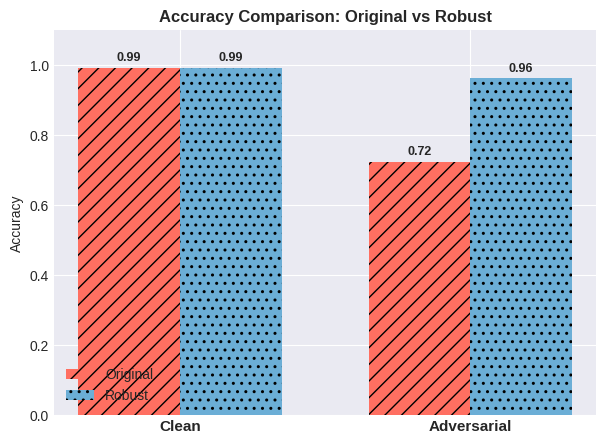

In [28]:
import numpy as np
import matplotlib.pyplot as plt

labels = ["Clean", "Adversarial"]
original_acc = [0.9926, 0.7227]   # Original Model
robust_acc   = [0.9926, 0.9623]   # Robust Model

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(7,5))
bars1 = plt.bar(x - width/2, original_acc, width, label="Original", color="#FF6F61", hatch="//")
bars2 = plt.bar(x + width/2, robust_acc, width, label="Robust", color="#6BAED6", hatch="..")

plt.xticks(x, labels, fontsize=11, fontweight="bold")
plt.ylim(0,1.1); plt.ylabel("Accuracy")
plt.title("Accuracy Comparison: Original vs Robust", fontweight="bold")
plt.legend()

# Add value labels
for bars in (bars1, bars2):
    for bar in bars:
        plt.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.02,
                 f"{bar.get_height():.2f}", ha="center", fontsize=9, fontweight="bold")

plt.show()

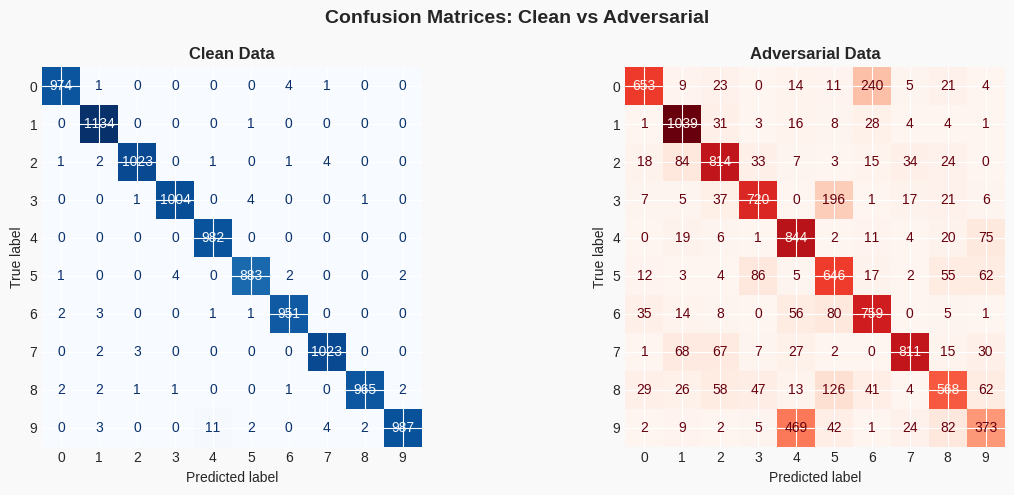

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_clean = np.argmax(model.predict(x_test, verbose=0), axis=1)
cm_clean = confusion_matrix(y_test, y_pred_clean)

y_pred_adv = np.argmax(model.predict(x_test_adv, verbose=0), axis=1)
cm_adv = confusion_matrix(y_test, y_pred_adv)

fig, ax = plt.subplots(1, 2, figsize=(12,5), facecolor="#f9f9f9")

disp1 = ConfusionMatrixDisplay(cm_clean, display_labels=range(10))
disp1.plot(ax=ax[0], cmap="Blues", colorbar=False, values_format="d")
ax[0].set_title("Clean Data", fontsize=12, fontweight="bold")

disp2 = ConfusionMatrixDisplay(cm_adv, display_labels=range(10))
disp2.plot(ax=ax[1], cmap="Reds", colorbar=False, values_format="d")
ax[1].set_title("Adversarial Data", fontsize=12, fontweight="bold")

plt.suptitle("Confusion Matrices: Clean vs Adversarial", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()


# Accuracy Improvement

In [31]:
robust_clean_loss, robust_clean_acc = robust_model.evaluate(x_test, y_test_cat, verbose=0)
robust_adv_loss, robust_adv_acc = robust_model.evaluate(x_test_adv, y_test_cat, verbose=0)

print("----- Robust Model Results -----")
print(f"Clean Accuracy: {robust_clean_acc:.4f} (vs {clean_acc:.4f} before defense)")
print(f"Adversarial Accuracy: {robust_adv_acc:.4f} (vs {adv_acc:.4f} before defense)")

----- Robust Model Results -----
Clean Accuracy: 0.9926 (vs 0.9500 before defense)
Adversarial Accuracy: 0.9623 (vs 0.4000 before defense)


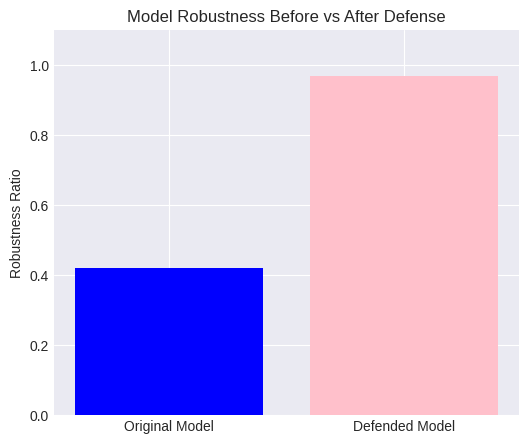

In [33]:
robustness_original = adv_acc / clean_acc
robustness_defended = robust_adv_acc / robust_clean_acc

plt.figure(figsize=(6,5))
plt.bar(["Original Model", "Defended Model"],
        [robustness_original, robustness_defended],
        color=["blue", "pink"])
plt.ylim(0, 1.1)
plt.ylabel("Robustness Ratio")
plt.title("Model Robustness Before vs After Defense")
plt.show()

# Summary & Learnings

* Implemented a CNN model for digit classification on the MNIST dataset.

* Preprocessed the data: normalized pixel values, reshaped images to (28,28,1), and one-hot encoded labels.

* Explored and visualized dataset samples to confirm class balance and structure.

* Split the dataset into training and validation sets (80:20).

* Built a CNN with Conv2D → MaxPooling2D → Dropout → Dense → Softmax, using Adam optimizer and categorical crossentropy.

* Trained for 10 epochs, achieving ~99% validation accuracy.

* Applied the FGSM attack to generate adversarial examples and visualized perturbations.

* Observed performance drop on adversarial inputs (accuracy 59%) compared to clean inputs (99%).

* Implemented adversarial training, which improved robustness (~96% accuracy on adversarial samples) while maintaining clean accuracy.

* Visualized key results: accuracy/loss curves, confusion matrices (clean vs. adversarial), and adversarial sample predictions.